In [1]:
import sys
import pandas as pd
import nflreadpy as nfl
from tqdm import tqdm

sys.path.append('../py')
from preprocess import preprocess
from nflplotlib import nflplot as nfp

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [43]:
sup_data = pd.read_csv('../data/supplementary_data.csv')
tracking_input, tracking_output = pd.DataFrame(), pd.DataFrame()
for week in tqdm(range(1, 19), desc="Loading weekly data"):
    tracking_input = pd.concat([tracking_input, pd.read_csv(f'../data/train/input_2023_w{week:02d}.csv')], axis=0)
    tracking_output = pd.concat([tracking_output, pd.read_csv(f'../data/train/output_2023_w{week:02d}.csv')], axis=0)

games, plays, players, tracking = preprocess.process_data(tracking_input, tracking_output, sup_data)
team_desc = preprocess.fetch_team_desc()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_17594/3341003902.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  sup_data = pd.read_csv('../data/supplementary_data.csv')
Loading weekly data: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]
2025-12-14 12:36:05,713 - INFO - Joined input and output tracking data: 14108 unique plays, 1384 unique nfl_ids
2025-12-14 12:36:05,714 - INFO - Standardizing direction of play and players to be left to right
2025-12-14 12:36:06,840 - INFO - Approximating missing speed, acceleration and direction values
2025-12-14 12:36:09,488 - INFO - Correlation results for imputations: s_approx: speed R²=0.9897 | a_approx: accel R²=0.0445 | dir_approx: dir R²=0.0442
2025-12-14 12:36:10,084 - INFO - Joining supplemental data to plays DataFrame
2025-12-14 12:36:10,119 - INFO - Loading NFL PBP data for season 2023
2025-12-14 12:36:10,119 - INFO - Loading pbp from local parquet file
2025-12-14 12:3

In [3]:
cmp_results = (
    pd.read_parquet('../data/results/cmp_preds.parquet')
    .merge(
        plays[['gpid', 'absolute_yardline_number', 'ball_land_x', 'ball_land_y','num_frames_output']],
        on='gpid', how='left')
    .assign(
        x=lambda x: x['absolute_yardline_number'] + x['x'],
        start_x=lambda x: x['absolute_yardline_number'] + x['start_x'],
    )
)
cmp_results.head()

,gpid,safety_nfl_id,sample_type,x,y,vx,vy,start_x,start_y,start_dir,start_s,predicted_cmp,absolute_yardline_number,ball_land_x,ball_land_y,num_frames_output
0,2023090700_101,46137,original,62.870000,4.630000,2.600729,-7.501987,53.08,20.04,326.31,2.59,0.023005,42.0,63.259998,-0.22,21.0
1,2023090700_101,46137,simulated,72.955746,15.432903,6.819203,-1.580656,53.08,20.04,326.31,2.59,0.536439,42.0,63.259998,-0.22,21.0
2,2023090700_101,46137,simulated,73.159746,16.682307,6.904139,-1.154496,53.08,20.04,326.31,2.59,0.541462,42.0,63.259998,-0.22,21.0
3,2023090700_101,46137,simulated,73.280823,17.979474,6.963866,-0.710329,53.08,20.04,326.31,2.59,0.545873,42.0,63.259998,-0.22,21.0
4,2023090700_101,46137,simulated,73.310887,19.321168,6.995585,-0.248563,53.08,20.04,326.31,2.59,0.549383,42.0,63.259998,-0.22,21.0


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull
from matplotlib.path import Path

def plot_safety_reach_heatmap(df, model_type="epa", tracking=None):
    """
    Heatmap of predicted EPA / INT / CMP over safety reach,
    with full player context and ball trajectory.
    """

    # -----------------------------
    # Prediction config
    # -----------------------------
    pred_map = {
        "epa": ("predicted_epa", "RdYlGn_r", "Predicted EPA"),
        "int": ("predicted_int", "coolwarm", "Predicted INT Probability"),
        "cmp": ("predicted_cmp", "viridis", "Predicted Completion Probability"),
    }

    if model_type not in pred_map:
        raise ValueError("model_type must be 'epa', 'int', or 'cmp'")

    pred_col, cmap, cbar_label = pred_map[model_type]

    # -----------------------------
    # Filter to safety
    # -----------------------------
    safety_nfl_id = df["safety_nfl_id"].iloc[0]
    gpid = df["gpid"].iloc[0]
    df = df.query("safety_nfl_id == @safety_nfl_id")

    # Safety start
    start_x = df["start_x"].iloc[0]
    start_y = df["start_y"].iloc[0]
    start_dir = np.deg2rad(df["start_dir"].iloc[0])
    start_speed = df["start_s"].iloc[0]
    start_dx = np.cos(start_dir) * start_speed * 0.5
    start_dy = np.sin(start_dir) * start_speed * 0.5

    # Safety final (actual)
    original = df.query("sample_type == 'original'").iloc[0]
    end_x, end_y = original["x"], original["y"]
    end_dx = original["vx"] * 0.5
    end_dy = original["vy"] * 0.5

    # -----------------------------
    # Simulated surface
    # -----------------------------
    sim = df.query("sample_type == 'simulated'")
    xs, ys = sim["x"].values, sim["y"].values
    preds = sim[pred_col].values

    xi = np.linspace(xs.min(), xs.max(), 200)
    yi = np.linspace(ys.min(), ys.max(), 200)
    xi_grid, yi_grid = np.meshgrid(xi, yi)

    zi_grid = griddata(
        (xs, ys), preds,
        (xi_grid, yi_grid),
        method="cubic", fill_value=np.nan
    )

    # Convex hull mask
    hull = ConvexHull(np.column_stack((xs, ys)))
    hull_path = Path(np.column_stack((xs, ys))[hull.vertices])
    mask = hull_path.contains_points(
        np.column_stack((xi_grid.ravel(), yi_grid.ravel()))
    ).reshape(xi_grid.shape)
    zi_grid[~mask] = np.nan

    # -----------------------------
    # Plot surface
    # -----------------------------
    plt.figure(figsize=(11, 7))

    im = plt.contourf(
        xi_grid, yi_grid, zi_grid,
        levels=40, cmap=cmap, alpha=0.8, zorder=2
    )
    plt.contour(
        xi_grid, yi_grid, zi_grid,
        levels=10, linewidths=0.6, alpha=0.3, zorder=3
    )

    # -----------------------------
    # Safety start + vectors
    # -----------------------------
    plt.scatter(start_x, start_y, s=60, color="grey",
                edgecolors="black", linewidths=2,
                label="Safety Start", zorder=6)

    plt.arrow(start_x, start_y, start_dx, start_dy,
              head_width=0.5, head_length=0.8,
              fc="black", ec="black", zorder=6)

    # Safety final + vector
    plt.scatter(end_x, end_y, s=60, color="black",
                edgecolors="black", linewidths=2,
                label="Safety Final", zorder=7)

    plt.arrow(end_x, end_y, end_dx, end_dy,
              head_width=0.5, head_length=0.8,
              fc="black", ec="black", zorder=7)

    # -----------------------------
    # Ball: start, landing, path
    # -----------------------------
    ball_x, ball_y = df["ball_land_x"].iloc[0], df["ball_land_y"].iloc[0]

    if tracking is not None:
        ball_start_frame = tracking.query(
            "gpid == @gpid & ~pass_thrown"
        ).frame_id.max()

        ball_start = tracking.query(
            "gpid == @gpid & frame_id == @ball_start_frame & player_side == 'Ball'"
        )

        bsx, bsy = ball_start.x.values[0], ball_start.y.values[0]

        plt.scatter(bsx, bsy, marker="x", s=100,
                    color="brown", label="Ball Start", zorder=8)

        plt.plot([bsx, ball_x], [bsy, ball_y],
                 linestyle="--", color="brown",
                 label="Ball Path", zorder=1)

    plt.scatter(ball_x, ball_y, marker="x", s=100,
                color="red", label="Ball Landing", zorder=8)

    # -----------------------------
    # Players + vectors (last frame)
    # -----------------------------
    if tracking is not None:
        last_frame = tracking.query("gpid == @gpid").frame_id.max()
        frame = tracking.query("gpid == @gpid & frame_id == @last_frame")

        defenders = frame.query(
            "player_side == 'Defense' & nfl_id != @safety_nfl_id"
        )
        offense = frame.query("player_side == 'Offense'")

        plt.scatter(defenders.x, defenders.y, s=50,
                    color="orange", edgecolors="black",
                    label="Other Defenders", zorder=6)

        plt.scatter(offense.x, offense.y, s=50,
                    color="cyan", edgecolors="black",
                    label="Receivers / Offense", zorder=6)

        for _, row in pd.concat([defenders, offense]).iterrows():
            rad = np.deg2rad(row["dir"])
            plt.arrow(
                row["x"], row["y"],
                np.cos(rad) * row["s"] * 0.5,
                np.sin(rad) * row["s"] * 0.5,
                head_width=0.3, head_length=0.5,
                fc="black", ec="black", zorder=7
            )

    # -----------------------------
    # Yardline
    # -----------------------------
    yardline = df["absolute_yardline_number"].iloc[0]
    plt.axvline(x=yardline, linestyle="--",
                color="purple", label="Absolute Yardline")

    # -----------------------------
    # Final touches
    # -----------------------------
    plt.axis("equal")
    plt.grid(alpha=0.3)
    plt.tight_layout()

    cbar = plt.colorbar(im)
    cbar.set_label(cbar_label)

    plt.legend(bbox_to_anchor=(-0.45, 1), loc="upper left")
    plt.show()


(:45) (No Huddle, Shotgun) P.Mahomes pass deep left to Ju.Watson pushed ob at DET 4 for 26 yards (C.Gardner-Johnson).


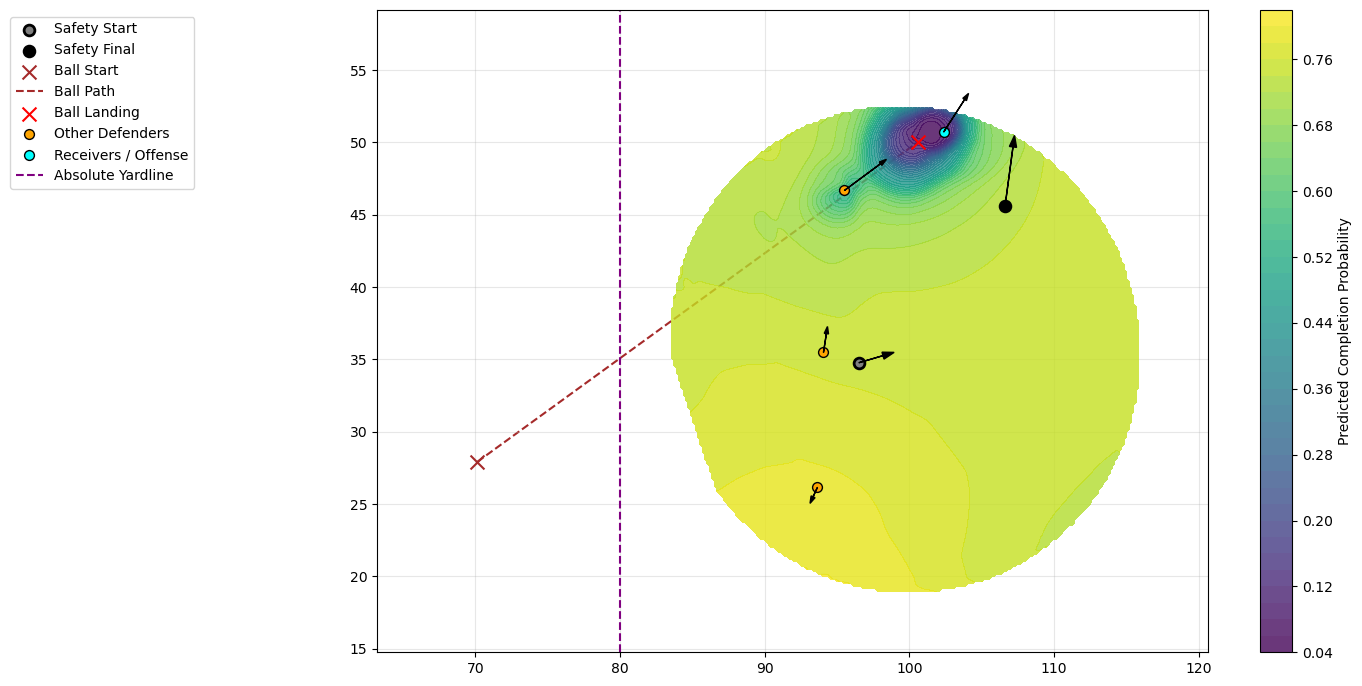

In [17]:
gpid = cmp_results['gpid'].unique()[5]
ex_df = cmp_results[cmp_results['gpid'] == gpid]
print(plays.query("gpid == @gpid").play_description.values[0])
plot_safety_reach_heatmap(ex_df, model_type="cmp", tracking=tracking)

In [5]:
epa_results = (
    pd.read_parquet('../data/results/epa_preds.parquet')
    .merge(
        plays[['gpid', 'absolute_yardline_number', 'ball_land_x', 'ball_land_y','num_frames_output']],
        on='gpid', how='left')
    .assign(
        x=lambda x: x['absolute_yardline_number'] + x['x'],
        start_x=lambda x: x['absolute_yardline_number'] + x['start_x'],
    )
)
epa_results.head()

,gpid,safety_nfl_id,sample_type,x,y,vx,vy,start_x,start_y,start_dir,start_s,predicted_epa,absolute_yardline_number,ball_land_x,ball_land_y,num_frames_output
0,2023090700_101,46137,original,62.870000,4.630000,2.600729,-7.501987,53.08,20.04,326.31,2.59,-1.632715,42.0,63.259998,-0.22,21.0
1,2023090700_101,46137,simulated,72.955746,15.432903,6.819203,-1.580656,53.08,20.04,326.31,2.59,1.079599,42.0,63.259998,-0.22,21.0
2,2023090700_101,46137,simulated,73.159746,16.682307,6.904139,-1.154496,53.08,20.04,326.31,2.59,1.119911,42.0,63.259998,-0.22,21.0
3,2023090700_101,46137,simulated,73.280823,17.979474,6.963866,-0.710329,53.08,20.04,326.31,2.59,1.169611,42.0,63.259998,-0.22,21.0
4,2023090700_101,46137,simulated,73.310887,19.321168,6.995585,-0.248563,53.08,20.04,326.31,2.59,1.223893,42.0,63.259998,-0.22,21.0


In [41]:
int_results = (
    pd.read_parquet('../data/results/int_preds.parquet')
    .merge(
        plays[['gpid', 'absolute_yardline_number', 'ball_land_x', 'ball_land_y','num_frames_output']],
        on='gpid', how='left')
    .assign(
        x=lambda x: x['absolute_yardline_number'] + x['x'],
        start_x=lambda x: x['absolute_yardline_number'] + x['start_x'],
    )
)
int_results.head()

,gpid,safety_nfl_id,sample_type,x,y,vx,vy,start_x,start_y,start_dir,start_s,predicted_int,absolute_yardline_number,ball_land_x,ball_land_y,num_frames_output
0,2023090700_101,46137,original,62.870000,4.630000,2.600729,-7.501987,53.08,20.04,326.31,2.59,0.309517,42.0,63.259998,-0.22,21.0
1,2023090700_101,46137,simulated,72.955746,15.432903,6.819203,-1.580656,53.08,20.04,326.31,2.59,0.305239,42.0,63.259998,-0.22,21.0
2,2023090700_101,46137,simulated,73.159746,16.682307,6.904139,-1.154496,53.08,20.04,326.31,2.59,0.303936,42.0,63.259998,-0.22,21.0
3,2023090700_101,46137,simulated,73.280823,17.979474,6.963866,-0.710329,53.08,20.04,326.31,2.59,0.302665,42.0,63.259998,-0.22,21.0
4,2023090700_101,46137,simulated,73.310887,19.321168,6.995585,-0.248563,53.08,20.04,326.31,2.59,0.301418,42.0,63.259998,-0.22,21.0


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull
from matplotlib.path import Path

def plot_safety_reach_heatmap(df, model_type="epa", tracking=None):
    """
    Plot a heatmap of predicted EPA or Interception probability for a safety's reach,
    including all players, ball path, and vectors.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain:
        - x, y, vx, vy for simulated/original points
        - start_x, start_y, start_dir, start_s for the safety origin
        - predicted_epa OR predicted_int depending on model_type
        - sample_type ('original' or 'simulated')
    model_type : str
        "epa" or "int". Determines which prediction column to use.
    tracking : pd.DataFrame, optional
        Full tracking data for the play, needed to plot other players.
    """

    # Choose prediction column
    pred_col = "predicted_epa" if model_type == "epa" else "predicted_int"

    # Filter to safety
    safety_nfl_id = df["safety_nfl_id"].iloc[0]
    print("Plotting for Safety NFL ID:", safety_nfl_id)
    df = df.query('safety_nfl_id == @safety_nfl_id')

    # Safety start info
    start_x = df["start_x"].iloc[0]
    start_y = df["start_y"].iloc[0]
    dir_rad = np.deg2rad(df["start_dir"].iloc[0])
    speed = df["start_s"].iloc[0]
    vec_dx = np.cos(dir_rad) * speed
    vec_dy = np.sin(dir_rad) * speed

    # Simulated points
    sim = df[df["sample_type"] == "simulated"]
    xs, ys = sim["x"].values, sim["y"].values
    preds = sim[pred_col].values

    # Interpolation grid
    grid_res = 200
    xi = np.linspace(xs.min(), xs.max(), grid_res)
    yi = np.linspace(ys.min(), ys.max(), grid_res)
    xi_grid, yi_grid = np.meshgrid(xi, yi)
    zi_grid = griddata((xs, ys), preds, (xi_grid, yi_grid), method='cubic', fill_value=np.nan)

    # Mask outside convex hull
    points = np.column_stack((xs, ys))
    hull = ConvexHull(points)
    hull_path = Path(points[hull.vertices])
    mask = hull_path.contains_points(np.column_stack((xi_grid.ravel(), yi_grid.ravel()))).reshape(xi_grid.shape)
    zi_grid[~mask] = np.nan

    # --- Plot ---
    plt.figure(figsize=(10, 6))
    cmap = "RdYlGn_r" if model_type=="epa" else "coolwarm"
    im = plt.contourf(xi_grid, yi_grid, zi_grid, levels=40, cmap=cmap, alpha=0.8, zorder=3)
    plt.contour(xi_grid, yi_grid, zi_grid, levels=10, alpha=0.3, linewidths=0.5, zorder=4)

    # Safety start
    plt.scatter(start_x, start_y, color="grey", s=50, label="Safety start", zorder=6, edgecolors='black', linewidths=2)
    plt.arrow(start_x, start_y, vec_dx, vec_dy, head_width=0.5, head_length=0.8, fc="black", ec="black", linewidth=1, zorder=5)

    # Safety actual end
    original = df[df["sample_type"] == "original"].iloc[0]
    plt.scatter(original["x"], original["y"], color="black", s=50, label="Safety actual end", zorder=6, edgecolors='black', linewidths=2)

    # Ball start
    if tracking is not None:
        gpid = df["gpid"].iloc[0]
        ball_start_frame = tracking.query('gpid == @gpid & ~pass_thrown').frame_id.max()
        ball_start = tracking.query('gpid == @gpid & frame_id == @ball_start_frame & player_side == "Ball"')
        plt.scatter(ball_start.x, ball_start.y, marker='x', color='brown', s=100, label='Ball Start', zorder=7)
        ball_start_x, ball_start_y = ball_start.x.values[0], ball_start.y.values[0]
    else:
        ball_start_x, ball_start_y = None, None

    # Ball landing
    ball_x, ball_y = df["ball_land_x"].iloc[0], df["ball_land_y"].iloc[0]
    plt.scatter(ball_x, ball_y, marker='x', color='red', s=100, label='Ball Landing', zorder=7)

    # Ball path
    if ball_start_x is not None:
        plt.plot([ball_start_x, ball_x], [ball_start_y, ball_y], color='brown', linestyle='--', label='Ball Path', zorder=2)

    # Absolute yardline
    yardline = df["absolute_yardline_number"].iloc[0]
    plt.axvline(x=yardline, color='purple', linestyle='--', label='Absolute Yardline', zorder=2)

    # Plot last frame offense and defense
    if tracking is not None:
        last_frame = tracking.query('gpid == @gpid').frame_id.max()
        last_frame_data = tracking.query('gpid == @gpid & frame_id == @last_frame')
        defenders = last_frame_data.query('player_side == "Defense" & nfl_id != @safety_nfl_id')
        offenses = last_frame_data.query('player_side == "Offense"')

        # Scatter positions
        plt.scatter(defenders.x, defenders.y, color='orange', s=50, label='Defenders', zorder=6, edgecolors='black', linewidths=1)
        plt.scatter(offenses.x, offenses.y, color='cyan', s=50, label='Offense', zorder=9, edgecolors='black', linewidths=1)

        # Movement arrows
        for df_arrow, color in zip([offenses, defenders], ['black','black']):
            for _, row in df_arrow.iterrows():
                rad = np.deg2rad(row['dir'])
                plt.arrow(row['x'], row['y'], np.cos(rad)*row['s']*0.5, np.sin(rad)*row['s']*0.5,
                          head_width=0.3, head_length=0.5, fc=color, ec=color, linewidth=1, zorder=7)

    # --- Final touches ---
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    cbar = plt.colorbar(im)
    cbar.set_label("Predicted EPA" if model_type=="epa" else "Predicted Int Probability")
    plt.legend(bbox_to_anchor=(-.5, 1), loc='upper left')
    plt.show()


In [8]:
import numpy as np

def compute_decision_efficiency(df, gpid, safety_nfl_id, model_type="epa"):
    """
    Compute multiple decision efficiency metrics for a safety's play.
    Rounds all results to 2 decimal places.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'predicted_epa' or 'predicted_int', 'sample_type',
        'gpid', 'safety_nfl_id'.
    gpid : str
        Play ID.
    safety_nfl_id : int
        Safety NFL ID.
    model_type : str
        "epa" or "int". Determines which column to use.

    Returns
    -------
    dict with actual value and three decision efficiency metrics.
    """
    pred_col = "predicted_epa" if model_type == "epa" else "predicted_int"

    original = df.query(
        'gpid == @gpid & safety_nfl_id == @safety_nfl_id & sample_type == "original"'
    )
    simulated = df.query(
        'gpid == @gpid & safety_nfl_id == @safety_nfl_id & sample_type == "simulated"'
    )

    act_val = original[pred_col].values[0]
    sim_vals = simulated[pred_col].values

    min_val = sim_vals.min()
    max_val = sim_vals.max()

    # --- Min/Max Decision Efficiency ---
    if model_type == "epa":
        decision_eff_minmax = (max_val - act_val) / (max_val - min_val)
    else:  # int probability
        decision_eff_minmax = (act_val - min_val) / (max_val - min_val)

    # --- Quantile-based Decision Efficiency (10th to 90th percentile) ---
    q_low, q_high = np.percentile(sim_vals, [10, 90])
    if model_type == "epa":
        decision_eff_quantile = (q_high - act_val) / (q_high - q_low)
    else:
        decision_eff_quantile = (act_val - q_low) / (q_high - q_low)

    # --- Rank-based Decision Efficiency ---
    if model_type == "epa":
        rank = (sim_vals < act_val).sum()  # smaller is better
    else:
        rank = (sim_vals > act_val).sum()  # larger is better
    decision_eff_rank = 1 - rank / (len(sim_vals) - 1)

    return {
        "actual": round(act_val, 2),
        "min": round(min_val, 2),
        "max": round(max_val, 2),
        "decision_eff_minmax": round(decision_eff_minmax, 2),
        "decision_eff_quantile": round(decision_eff_quantile, 2),
        "decision_eff_rank": round(decision_eff_rank, 2)
    }

import json

# --- Example usage ---
gpid = "2023091009_2499"
safety_nfl_id = 43387

epa_metrics = compute_decision_efficiency(epa_results, gpid, safety_nfl_id, model_type="epa")
# int_metrics = compute_decision_efficiency(int_results, gpid, safety_nfl_id, model_type="int")

print("EPA Decision Efficiency:", json.dumps(epa_metrics, indent=2))
# print("INT Probability Decision Efficiency:", json.dumps(int_metrics, indent=2))

EPA Decision Efficiency: {
  "actual": 1.14,
  "min": -2.42,
  "max": 2.32,
  "decision_eff_minmax": 0.25,
  "decision_eff_quantile": 1.1,
  "decision_eff_rank": 0.93
}


In [16]:
def decision_eff_rank_group(df, pred_col, model_type):
    """
    Compute rank-based decision efficiency for one (gpid, safety_nfl_id) group.
    """
    original = df.loc[df["sample_type"] == "original", pred_col].values
    simulated = df.loc[df["sample_type"] == "simulated", pred_col].values

    if len(original) == 0 or len(simulated) < 2:
        return np.nan

    act_val = original[0]

    if model_type == "epa":
        # smaller is better
        rank = (simulated < act_val).sum()
    else:
        # larger is better
        rank = (simulated > act_val).sum()

    return 1 - rank / (len(simulated) - 1)

def decision_eff_quantile_group(df, pred_col, model_type):
    """
    Compute quantile-based decision efficiency for one (gpid, safety_nfl_id) group.
    """
    original = df.loc[df["sample_type"] == "original", pred_col].values
    simulated = df.loc[df["sample_type"] == "simulated", pred_col].values

    if len(original) == 0 or len(simulated) < 2:
        return np.nan

    q_low, q_high = np.percentile(simulated, [10, 90])
    act_val = min(max(q_low, original[0]), q_high)  # clamp to [q_low, q_high]
    
    if model_type == "epa":
        return (q_high - act_val) / (q_high - q_low)
    else:
        return (act_val - q_low) / (q_high - q_low)


In [42]:
epa_rank = (
    epa_results
    .groupby(["gpid", "safety_nfl_id"])
    .apply(
        lambda g: decision_eff_rank_group(
            g, pred_col="predicted_epa", model_type="epa"
        )
    )
    .rename("decision_eff_rank_epa")
    .reset_index()
)

epa_quantile = (
    epa_results
    .groupby(["gpid", "safety_nfl_id"])
    .apply(
        lambda g: decision_eff_quantile_group(
            g, pred_col="predicted_epa", model_type="epa"
        )
    )
    .rename("decision_eff_quantile_epa")
    .reset_index()
)

epa_rank_df = epa_rank.merge(
    epa_quantile,
    on=["gpid", "safety_nfl_id"],
    how="inner"
)


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_63813/2907626006.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_63813/2907626006.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [43]:
int_rank_df = (
    int_results
    .groupby(["gpid", "safety_nfl_id"], as_index=False)
    .apply(
        lambda g: decision_eff_rank_group(
            g, pred_col="predicted_int", model_type="int"
        )
    )
    .rename(columns={None: "decision_eff_rank_int"})
)
int_quantile_df = (
    int_results
    .groupby(["gpid", "safety_nfl_id"], as_index=False)
    .apply(
        lambda g: decision_eff_quantile_group(
            g, pred_col="predicted_int", model_type="int"
        )
    )
    .rename(columns={None: "decision_eff_quantile_int"})
)
int_rank_df = (
    int_rank_df.merge(
        int_quantile_df,
        on=["gpid", "safety_nfl_id"],
        how="inner"
    )
)

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_63813/1952812930.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_63813/1952812930.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [44]:
decision_eff_df = (
    epa_rank_df
    .merge(
        int_rank_df,
        on=["gpid", "safety_nfl_id"],
        how="left"
    )
    .merge(
        players[['nfl_id','player_name']].rename(columns={'nfl_id':'safety_nfl_id'}),
        on='safety_nfl_id', how='left'
    )
)

decision_eff_df.head()

,gpid,safety_nfl_id,decision_eff_rank_epa,decision_eff_quantile_epa,decision_eff_rank_int,decision_eff_quantile_int,player_name
0,2023090700_101,46137,0.967360,1.000000,0.940634,1.000000,Justin Reid
1,2023090700_1422,47888,0.966601,1.000000,0.984619,1.000000,C.J. Gardner-Johnson
2,2023090700_1494,54527,0.553829,0.292261,0.064373,0.000000,Bryan Cook
3,2023090700_1588,47888,0.922634,1.000000,0.837170,0.893808,C.J. Gardner-Johnson
4,2023090700_1588,54562,0.953269,1.000000,0.674384,0.602185,Kerby Joseph


In [45]:
(
    decision_eff_df.groupby(['safety_nfl_id']).aggregate({
        'player_name':'first',
        'gpid':'count',
        'decision_eff_rank_epa':'mean',
        'decision_eff_rank_int':'mean',
    })
    .rename(columns={'gpid':'num_plays'})
    .query('num_plays >= 5')
    .sort_values(by='decision_eff_rank_epa', ascending=False)
    .assign(
        decision_eff_rank_epa=lambda x: round(x['decision_eff_rank_epa'], 2),
        decision_eff_rank_int=lambda x: round(x['decision_eff_rank_int'], 2),
        # decision_eff_rank_int=lambda x: round(x['decision_eff_rank_int
        # rank_rk=lambda x: x['decision_eff_rank_epa'].rank(ascending=False).astype(int),
        # quant_rk=lambda x: x['decision_eff_quantile_epa'].rank(ascending=False).astype(int)
    )
    .sort_values(by='decision_eff_rank_epa', ascending=False, ignore_index=True)
)

,player_name,num_plays,decision_eff_rank_epa,decision_eff_rank_int
0,Johnathan Abram,7,0.87,0.71
1,Lonnie Johnson,8,0.82,0.75
2,Chamarri Conner,10,0.81,0.81
3,Sydney Brown,11,0.79,0.69
4,P.J. Locke,28,0.78,0.84
5,M.J. Stewart,7,0.77,0.81
6,Justin Reid,32,0.76,0.72
7,DeMarcco Hellams,17,0.75,0.77
8,Xavier McKinney,36,0.74,0.83
9,John Johnson,36,0.74,0.73


In [46]:
(
    decision_eff_df.groupby(['safety_nfl_id']).aggregate({
        'player_name':'first',
        'gpid':'count',
        'decision_eff_rank_epa':'mean',
        'decision_eff_rank_int':'mean',
    })
    .rename(columns={'gpid':'num_plays'})
    .query('num_plays >= 5')
    .sort_values(by='decision_eff_rank_epa', ascending=False)
    .assign(
        decision_eff_rank_epa=lambda x: round(x['decision_eff_rank_epa'], 2),
        decision_eff_rank_int=lambda x: round(x['decision_eff_rank_int'], 2),
        # decision_eff_rank_int=lambda x: round(x['decision_eff_rank_int
        # rank_rk=lambda x: x['decision_eff_rank_epa'].rank(ascending=False).astype(int),
        # quant_rk=lambda x: x['decision_eff_quantile_epa'].rank(ascending=False).astype(int)
    )
    .sort_values(by='decision_eff_rank_int', ascending=False, ignore_index=True)
)

,player_name,num_plays,decision_eff_rank_epa,decision_eff_rank_int
0,Justin Evans,14,0.53,0.87
1,D'Anthony Bell,7,0.73,0.87
2,Dane Belton,14,0.65,0.84
3,Ryan Neal,21,0.62,0.84
4,P.J. Locke,28,0.78,0.84
5,Myles Bryant,8,0.65,0.83
6,Elijah Campbell,10,0.69,0.83
7,Xavier McKinney,36,0.74,0.83
8,Jalen Pitre,52,0.60,0.83
9,Delarrin Turner-Yell,10,0.66,0.82


In [47]:
plays.head()

,gpid,game_id,play_id,absolute_yardline_number,num_frames_output,ball_land_x,ball_land_y,season,week,play_description,quarter,game_clock,down,yards_to_go,possession_team,defensive_team,yardline_side,yardline_number,pre_snap_home_score,pre_snap_visitor_score,play_nullified_by_penalty,pass_result,pass_length,offense_formation,receiver_alignment,route_of_targeted_receiver,play_action,dropback_type,dropback_distance,pass_location_type,defenders_in_the_box,team_coverage_man_zone,team_coverage_type,penalty_yards,pre_penalty_yards_gained,yards_gained_x,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added,yards_gained_y,air_yards,yards_after_catch,pass_distance
0,2023090700_101,2023090700,101,42,21,63.259998,-0.22,2023,1,(14:25) (Shotgun) J.Goff pass incomplete deep ...,1,14:25,3,3,DET,KC,DET,32,0,0,N,I,22,SHOTGUN,2x2,CORNER,False,TRADITIONAL,2.13,INSIDE_BOX,6,ZONE_COVERAGE,COVER_2_ZONE,NaN,0,0,0.927021,-2.145443,0.590426,0.409574,0.049720,-0.049720,0.0,22.0,NaN,41.088520
1,2023090700_194,2023090700,194,31,9,35.059998,31.55,2023,1,(12:56) (Shotgun) P.Mahomes pass short left to...,1,12:56,3,2,KC,DET,KC,21,0,0,N,C,6,SHOTGUN,2x2,ANGLE,False,TRADITIONAL,3.86,INSIDE_BOX,6,MAN_COVERAGE,COVER_1_MAN,NaN,10,10,0.121505,1.702563,0.582476,0.417524,0.047277,-0.047277,10.0,6.0,4.0,14.950209
2,2023090700_219,2023090700,219,41,8,44.150002,41.81,2023,1,(12:20) (Shotgun) P.Mahomes pass short left to...,1,12:20,1,10,KC,DET,KC,31,0,0,N,C,4,SHOTGUN,2x2,HITCH,False,TRADITIONAL,2.37,INSIDE_BOX,6,ZONE_COVERAGE,COVER_4_ZONE,NaN,5,5,1.824068,0.089352,0.629753,0.370247,0.000420,-0.000420,5.0,4.0,1.0,15.237809
3,2023090700_361,2023090700,361,22,16,26.100000,49.18,2023,1,(10:06) (Shotgun) J.Goff pass short left to M....,1,10:06,3,7,DET,KC,DET,12,0,0,N,C,5,SHOTGUN,3x1,HITCH,False,TRADITIONAL,3.03,OUTSIDE_RIGHT,6,ZONE_COVERAGE,COVER_4_ZONE,NaN,5,5,-1.049160,-0.862062,0.606310,0.393690,0.019525,-0.019525,5.0,5.0,0.0,29.842495
4,2023090700_436,2023090700,436,31,7,34.889999,34.82,2023,1,(8:09) (Shotgun) J.Goff pass short left to A.S...,1,08:09,2,9,DET,KC,DET,21,0,0,N,C,6,SHOTGUN,2x2,SLANT,False,TRADITIONAL,2.55,INSIDE_BOX,6,MAN_COVERAGE,COVER_1_MAN,NaN,13,13,0.312204,1.613927,0.575537,0.424463,-0.030918,0.030918,13.0,6.0,7.0,12.158770


In [4]:
cmp_results.head()

,gpid,safety_nfl_id,sample_type,x,y,vx,vy,start_x,start_y,start_dir,start_s,predicted_cmp,absolute_yardline_number,ball_land_x,ball_land_y,num_frames_output
0,2023090700_101,46137,original,62.870000,4.630000,2.600729,-7.501987,53.08,20.04,326.31,2.59,0.023005,42.0,63.259998,-0.22,21.0
1,2023090700_101,46137,simulated,72.955746,15.432903,6.819203,-1.580656,53.08,20.04,326.31,2.59,0.536439,42.0,63.259998,-0.22,21.0
2,2023090700_101,46137,simulated,73.159746,16.682307,6.904139,-1.154496,53.08,20.04,326.31,2.59,0.541462,42.0,63.259998,-0.22,21.0
3,2023090700_101,46137,simulated,73.280823,17.979474,6.963866,-0.710329,53.08,20.04,326.31,2.59,0.545873,42.0,63.259998,-0.22,21.0
4,2023090700_101,46137,simulated,73.310887,19.321168,6.995585,-0.248563,53.08,20.04,326.31,2.59,0.549383,42.0,63.259998,-0.22,21.0


In [54]:
pbp = nfl.load_pbp(2023).to_pandas()[['old_game_id','play_id','interception_player_id']].assign(gpid=lambda x: x['old_game_id'].astype(str) + '_' + x['play_id'].astype(str))
pbp_ints = pbp[['gpid','interception_player_id']].drop_duplicates()
rosters = nfl.load_rosters(2023).to_pandas()[['gsis_id','gsis_it_id']].rename(columns={'gsis_id':'interception_player_id', 'gsis_it_id':'interception_nfl_id'})
rosters_unique = rosters[['interception_player_id','interception_nfl_id']].drop_duplicates()
cols = ['season', 'week',
       'play_description', 'quarter', 'game_clock', 'down', 'yards_to_go',
       'possession_team', 'defensive_team',
       'pre_snap_home_score', 'pre_snap_visitor_score',
        'pass_result',
       'yards_after_catch', 'pass_distance']
res = plays.merge(
    cmp_results[['gpid','safety_nfl_id']].drop_duplicates(),
    on='gpid',
    how='left'
).merge(
    pbp_ints,
    on='gpid',
    how='left'
).merge(
    rosters_unique,
    on='interception_player_id',
    how='left'
).query('pass_distance >= 30 and pass_distance <= 40 and pass_result == "IN"')[cols + ['safety_nfl_id','interception_nfl_id']]

In [55]:
res

,season,week,play_description,quarter,game_clock,down,yards_to_go,possession_team,defensive_team,pre_snap_home_score,pre_snap_visitor_score,pass_result,yards_after_catch,pass_distance,safety_nfl_id,interception_nfl_id
328,2023,1,(6:48) (Shotgun) R.Tannehill pass deep right i...,2,06:48,3,5,TEN,NO,6,6,IN,NaN,37.025251,44851.0,57034
341,2023,1,(3:14) (Shotgun) R.Tannehill pass deep right i...,3,03:14,3,5,TEN,NO,9,9,IN,NaN,30.038059,NaN,57034
364,2023,1,(8:08) (Shotgun) K.Pickett pass deep right int...,1,08:08,3,5,PIT,SF,0,7,IN,NaN,34.771891,38868.0,57034
607,2023,1,(4:39) (Shotgun) T.Tagovailoa pass deep left i...,3,04:39,3,12,MIA,LAC,24,20,IN,NaN,38.851947,52594.0,57034
1627,2023,2,(3:16) (Shotgun) D.Carr pass deep right intend...,2,03:16,3,4,NO,CAR,3,6,IN,NaN,30.070121,45004.0,57034
1907,2023,3,(:10) (Shotgun) J.Goff pass deep middle intend...,3,00:10,3,10,DET,ATL,13,3,IN,NaN,33.169602,46123.0,57034
1908,2023,3,(:10) (Shotgun) J.Goff pass deep middle intend...,3,00:10,3,10,DET,ATL,13,3,IN,NaN,33.169602,52542.0,57034
2481,2023,3,(7:25) J.Garoppolo pass deep right intended fo...,3,07:25,2,10,LV,PIT,7,16,IN,NaN,37.832129,44962.0,57034
2887,2023,4,(9:46) (Shotgun) D.Thompson-Robinson pass deep...,4,09:46,3,10,CLE,BAL,3,21,IN,NaN,38.480124,52627.0,57034
3011,2023,4,"(:46) (No Huddle, Shotgun) B.Mayfield pass dee...",2,00:46,2,2,TB,NO,3,7,IN,NaN,32.465599,40017.0,57034


In [40]:
res.shape

(8, 49)

In [28]:
res.safety_nfl_id.unique()

array([46137.,    nan, 54527., 47882., 47888., 54562., 46123., 53469.,
       43350., 54502., 44854., 52627., 54479., 46122., 52897., 53819.,
       52452., 44926., 53494., 54704., 52453., 38559., 46711., 53554.,
       52613., 44851., 53529., 43353., 40017., 44962., 38868., 46080.,
       43306., 53609., 44848., 49410., 52624., 52535., 53592., 54578.,
       47804., 45021., 54513., 44925., 47974., 53472., 43387., 35459.,
       52594., 46086., 46259., 53465., 44862., 54808., 52445., 44837.,
       47891., 42543., 54718., 52607., 52444., 44827., 53604., 55166.,
       53656., 40107., 40166., 46186., 42485., 54833.])